BERT STS

In [ ]:
!pip install transformers sentence-transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 901.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import datetime
import random
import numpy as np
import pandas as pd

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
dataset = load_dataset("stsb_multi_mt", "en")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Class to manage dataset
class STSBDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        # Normalize the similarity scores in the dataset
        similarity_scores = [i['similarity_score'] for i in dataset]
        self.normalized_similarity_scores = [i/6.0 for i in similarity_scores]
        self.first_sentences = [i['sentence1'] for i in dataset]
        self.second_sentences = [i['sentence2'] for i in dataset]
        self.concatenated_sentences = [[str(x), str(y)] for x,y in zip(self.first_sentences, self.second_sentences)]

    def __len__(self):

        return len(self.concatenated_sentences)

    def get_batch_labels(self, idx):

        return torch.tensor(self.normalized_similarity_scores[idx])

    def get_batch_texts(self, idx):

        return tokenizer(self.concatenated_sentences[idx], padding='max_length', max_length=128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


def collate_fn(texts):

    input_ids = texts['input_ids']
    attention_masks = texts['attention_mask']

    features = [{'input_ids': input_id, 'attention_mask': attention_mask}
                for input_id, attention_mask in zip(input_ids, attention_masks)]

    return features

In [ ]:
# Model class
class BertForSTS(torch.nn.Module):

    def __init__(self):

        super(BertForSTS, self).__init__()
        self.bert = models.Transformer('bert-base-uncased', max_seq_length=128)
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = SentenceTransformer(modules=[self.bert, self.pooling_layer])

    def forward(self, input_data):
        output = self.sts_bert(input_data)['sentence_embedding']
        return output

In [ ]:
# Instantiating the model and moving it to GPU
model = BertForSTS()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForSTS(
  (bert): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_layer): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (sts_bert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
)

In [ ]:
# Loss function based on Cosine Similarity
class CosineSimilarityLoss(torch.nn.Module):

    def __init__(self,  loss_fn=torch.nn.MSELoss(), transform_fn=torch.nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fn = loss_fn
        self.transform_fn = transform_fn
        self.cos_similarity = torch.nn.CosineSimilarity(dim=1)

    def forward(self, inputs, labels):
        emb_1 = torch.stack([inp[0] for inp in inputs])
        emb_2 = torch.stack([inp[1] for inp in inputs])
        outputs = self.transform_fn(self.cos_similarity(emb_1, emb_2))
        return self.loss_fn(outputs, labels.squeeze())

In [ ]:
# training and validation splits
train_ds = STSBDataset(dataset['train'])
val_ds = STSBDataset(dataset['dev'])

train_size = len(train_ds)
val_size = len(val_ds)

In [ ]:
batch_size = 8
train_dataloader = DataLoader(
            train_ds,  # training samples.
            num_workers = 4,
            batch_size = batch_size,
            shuffle=True # Select samples randomly for each batch
        )

validation_dataloader = DataLoader(
            val_ds,
            num_workers = 4,
            batch_size = batch_size
        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5)

epochs = 5 # possible values: 3, 5, 8

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# TRAIN FUNCTION
def train():
  seed_val = 42

  criterion = CosineSimilarityLoss()
  criterion = criterion.to(device)

  random.seed(seed_val)
  torch.manual_seed(seed_val)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []
  total_t0 = time.time()

  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      t0 = time.time()

      total_train_loss = 0

      model.train()

      # For each batch of training data...
      for train_data, train_label in tqdm(train_dataloader):

          train_data['input_ids'] = train_data['input_ids'].to(device)
          train_data['attention_mask'] = train_data['attention_mask'].to(device)

          train_data = collate_fn(train_data)
          model.zero_grad()

          output = [model(feature) for feature in train_data]

          loss = criterion(output, train_label.to(device))
          total_train_loss += loss.item()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()


      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.5f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================

      print("")
      print("Running Validation...")

      t0 = time.time()

      model.eval()

      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for val_data, val_label in tqdm(validation_dataloader):

          val_data['input_ids'] = val_data['input_ids'].to(device)
          val_data['attention_mask'] = val_data['attention_mask'].to(device)

          val_data = collate_fn(val_data)

          with torch.no_grad():
              output = [model(feature) for feature in val_data]

          loss = criterion(output, val_label.to(device))
          total_eval_loss += loss.item()

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.5f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return model, training_stats

In [ ]:
model, training_stats = train()
PATH = '/content/drive/MyDrive/IA_NLP/bert-sts-model-ep5.pt'
torch.save(model.state_dict(), PATH)


======== Epoch 1 / 5 ========
Training...


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 719/719 [05:09<00:00,  2.32it/s]



  Average training loss: 0.03223
  Training epoch took: 0:05:10

Running Validation...


100%|██████████| 188/188 [00:26<00:00,  7.20it/s]


  Validation Loss: 0.02664
  Validation took: 0:00:26

======== Epoch 2 / 5 ========
Training...


100%|██████████| 719/719 [05:13<00:00,  2.29it/s]



  Average training loss: 0.01334
  Training epoch took: 0:05:13

Running Validation...


100%|██████████| 188/188 [00:26<00:00,  7.16it/s]


  Validation Loss: 0.02641
  Validation took: 0:00:26

======== Epoch 3 / 5 ========
Training...


100%|██████████| 719/719 [05:11<00:00,  2.31it/s]



  Average training loss: 0.00697
  Training epoch took: 0:05:12

Running Validation...


100%|██████████| 188/188 [00:25<00:00,  7.23it/s]


  Validation Loss: 0.02625
  Validation took: 0:00:26

======== Epoch 4 / 5 ========
Training...


100%|██████████| 719/719 [05:10<00:00,  2.32it/s]



  Average training loss: 0.00501
  Training epoch took: 0:05:10

Running Validation...


100%|██████████| 188/188 [00:25<00:00,  7.35it/s]


  Validation Loss: 0.02597
  Validation took: 0:00:26

======== Epoch 5 / 5 ========
Training...


100%|██████████| 719/719 [05:10<00:00,  2.32it/s]



  Average training loss: 0.00395
  Training epoch took: 0:05:10

Running Validation...


100%|██████████| 188/188 [00:25<00:00,  7.28it/s]


  Validation Loss: 0.02592
  Validation took: 0:00:26

Training complete!
Total training took 0:28:05 (h:mm:ss)


In [ ]:
# training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.032230,0.026642,0:05:10,0:00:26
2,0.013336,0.026410,0:05:13,0:00:26
3,0.006974,0.026248,0:05:12,0:00:26
4,0.005014,0.025967,0:05:10,0:00:26
5,0.003954,0.025919,0:05:10,0:00:26


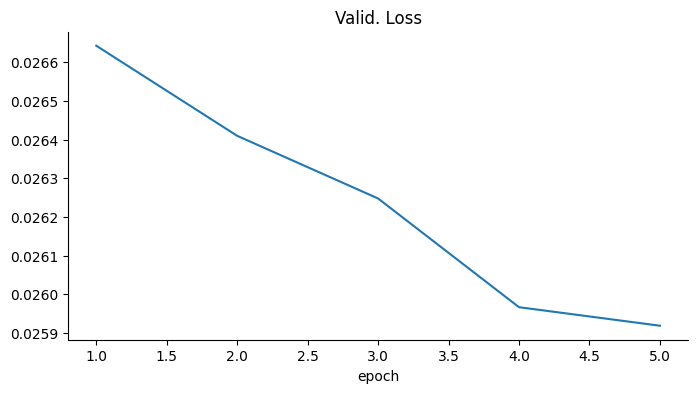

In [ ]:
# @title Valid. Loss

from matplotlib import pyplot as plt
df_stats['Valid. Loss'].plot(kind='line', figsize=(8, 4), title='Valid. Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

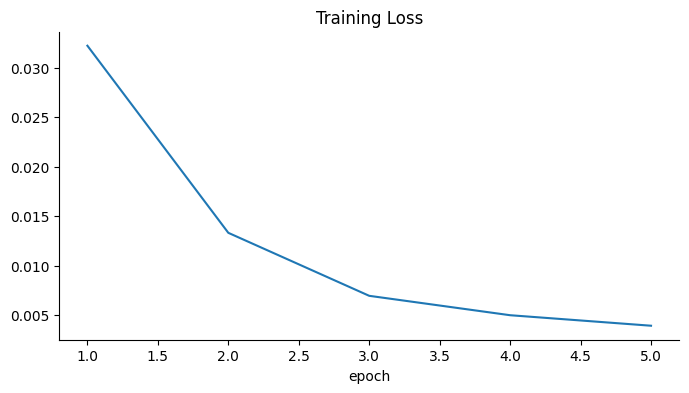

In [ ]:
# @title Training Loss

from matplotlib import pyplot as plt
df_stats['Training Loss'].plot(kind='line', figsize=(8, 4), title='Training Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# TEST
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")

# Prepare the data
first_sent = [i['sentence1'] for i in test_dataset]
second_sent = [i['sentence2'] for i in test_dataset]
full_text = [[str(x), str(y)] for x,y in zip(first_sent, second_sent)]

In [ ]:
test_dataset

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1379
})

In [ ]:
def predict_similarity(sentence_pair):

  test_input = tokenizer(sentence_pair, padding='max_length', max_length=128, truncation=True, return_tensors="pt").to(device)
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']

  output = model(test_input)
  sim = torch.nn.functional.cosine_similarity(output[0], output[1], dim=0).item()

  return sim

In [ ]:
import matplotlib.pyplot as plt

# Load the saved model
model_path = "/content/drive/MyDrive/IA_NLP/bert-sts-model-ep5.pt"
model.load_state_dict(torch.load(model_path))
model.eval()


actual_scores = []
predicted_scores = []

# Iterate through the test dataset
for example in test_dataset:
    # Extract data from the example
    sentence_pair = (example['sentence1'], example['sentence2'])
    actual_similarity = example['similarity_score'] / 6.0  # Normalize actual similarity by 6

    # Calculate predicted similarity
    predicted_similarity = predict_similarity(sentence_pair)

    # Append to lists
    actual_scores.append(actual_similarity)
    predicted_scores.append(predicted_similarity)

In [ ]:
# Create a dataframe
df = pd.DataFrame({'Actual': actual_scores, 'Predicted': predicted_scores})
df

,Actual,Predicted
0,0.50,0.712390
1,0.72,0.809454
2,1.00,0.930210
3,0.84,0.947322
4,0.30,0.319913
...,...,...
1374,0.00,0.410842
1375,0.20,0.152883
1376,0.20,0.225985
1377,0.00,0.120874


In [ ]:
# Define threshold for positive prediction
threshold = 0.5

# Calculate true positives, false positives, and false negatives
true_positives = ((df['Actual'] >= threshold) & (df['Predicted'] >= threshold)).sum()
false_positives = ((df['Actual'] < threshold) & (df['Predicted'] >= threshold)).sum()
false_negatives = ((df['Actual'] >= threshold) & (df['Predicted'] < threshold)).sum()

# Calculate precision and recall
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Precision: 0.81
Recall: 0.95
F1 Score: 0.87
